# Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
import geopy
!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Create required fuctions 

In [2]:
#Function to extract New York dataset
def get_newyork_dataset():
    url='https://cocl.us/new_york_dataset'
    # make the GET request
    ny_data=requests.get(url).json()
    # all data is present in features label
    features=ny_data['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'] 
    # instantiate the dataframe
    new_york_dataset = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        location = data['geometry']['coordinates']
        neighborhood_lat = location[1]
        neighborhood_lon = location[0]
        new_york_dataset = new_york_dataset.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Neighborhood Latitude': neighborhood_lat,
                                          'Neighborhood Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_dataset

# Defining Foursquare Credentials and Version
CLIENT_ID = 'CAFIXMYYEFJFP1RU0KH1WANUZC1PZBEGMC0NE4XUMVE3Y524' # your Foursquare ID
CLIENT_SECRET = 'ERRPO3CKGITL3QBIWECYO4VPSCLJGV1VUUZXDPJQE0QFQ0SX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#Function to explore venues from Forsquare API for preferred Locations/Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    #print(nearby_venues) 
    return(nearby_venues)


# Load and Explore New York data

In [3]:
newyork_data = get_newyork_dataset()
newyork_data.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
#information of New York data
newyork_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Borough                 306 non-null    object 
 1   Neighborhood            306 non-null    object 
 2   Neighborhood Latitude   306 non-null    float64
 3   Neighborhood Longitude  306 non-null    float64
dtypes: float64(2), object(2)
memory usage: 9.7+ KB


In [5]:
# Shape of new york data
print("Shape of New York data: ", newyork_data.shape)
print("Number of rows: ",newyork_data.shape[0] )
print("Number of columns: ", newyork_data.shape[1])

Shape of New York data:  (306, 4)
Number of rows:  306
Number of columns:  4


## Data Analysis and Visualizations

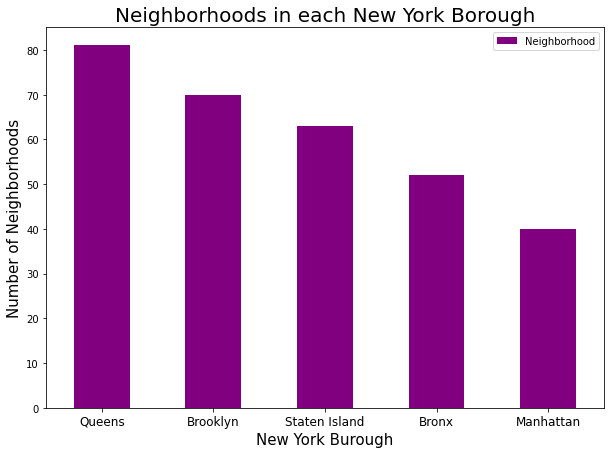

In [6]:
plt.figure(figsize = (10,7))
newyork_data.groupby("Borough").count().sort_values(by = "Neighborhood", ascending = False)["Neighborhood"].plot(kind ="bar", color = 'purple')
plt.xlabel("New York Burough", fontsize = 15)
plt.ylabel("Number of Neighborhoods", fontsize = 15)
plt.title("Neighborhoods in each New York Borough", fontsize = 20)
plt.xticks(rotation = 'horizontal', fontsize = 12)
plt.legend()
plt.show()


In [7]:
# Using geopy to get the latitude and longitude values of New York City
from geopy.geocoders import Nominatim

address = "New York City, NY"

geolocator = Nominatim(user_agent = "ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographical coordinates of New York city are {} and {}.".format(latitude, longitude))

The geographical coordinates of New York city are 40.7127281 and -74.0060152.


# Visualize the Neighborhoods and Buroughs of New York on a Map

In [8]:
# using folium to visualize the Neighborhoods and Buroughs of New York

map_newyork = folium.Map(location = [latitude, longitude], zoom_start =10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_data["Neighborhood Latitude"], newyork_data['Neighborhood Longitude'], newyork_data['Borough'], newyork_data['Neighborhood']):
  label = '{}, {}'.format(neighborhood, borough)
  label = folium.Popup(label, parse_html=False)
  folium.CircleMarker(
      location = [lat,lng],
      radius = 5,
      popup = label,
      color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
  ).add_to(map_newyork)

map_newyork  

# Utilize the Foursquare API to explore venues in the neighborhoods of New York and segment them

In [9]:
ny_venues = getNearbyVenues(names = newyork_data["Neighborhood"], latitudes = newyork_data["Neighborhood Latitude"], longitudes = newyork_data["Neighborhood Longitude"])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [10]:
# Checking the size of the resulting dataframe
print(ny_venues.shape)

(10112, 7)


In [11]:
# Saving the resulting data (ny_venues) to a .csv file due to limited calls on FourSquare
ny_venues.to_csv('ny_venues1.csv', index = False)

In [12]:
#Reading data from csv to padas dataframe for further analysis
venues_ny = pd.read_csv('ny_venues1.csv')
venues_ny.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [13]:
#Selecting only the rows that have Venue Category as Bakery for further analysis
ny_bakery = venues_ny[ny_venues["Venue Category"]== 'Bakery'].reset_index(drop= True)
#Adding Borough feature 
ny_bakery = ny_bakery.join(newyork_data[["Borough", "Neighborhood"]].set_index("Neighborhood"), on = 'Neighborhood')
ny_bakery = ny_bakery[["Borough", "Neighborhood", "Venue", "Venue Category", "Venue Latitude", "Venue Longitude"]]
print("Number of Bakeries in NY City: ", ny_bakery.shape[0])
ny_bakery.head()

Number of Bakeries in NY City:  250


,Borough,Neighborhood,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Bronx,Kingsbridge,S & S Cheesecake,Bakery,40.884793,-73.899861
1,Bronx,Kingsbridge,Sugarboy Bakery Cafe,Bakery,40.877948,-73.902860
2,Bronx,Kingsbridge,Stella D'oro Biscuit Co,Bakery,40.883202,-73.900436
3,Bronx,Bedford Park,Confectionaires Bakery,Bakery,40.867506,-73.883297
4,Bronx,University Heights,Au Bon Pain,Bakery,40.858062,-73.912040


##There are 245 Bakeries in all of New York City.

##Further analysis shows that Manhattan has the most number of Bakeries with Chelsea Neighborhood topping the list. There are 10 bakeries in Chelsea alone and it is located in Manhattan Burough. 

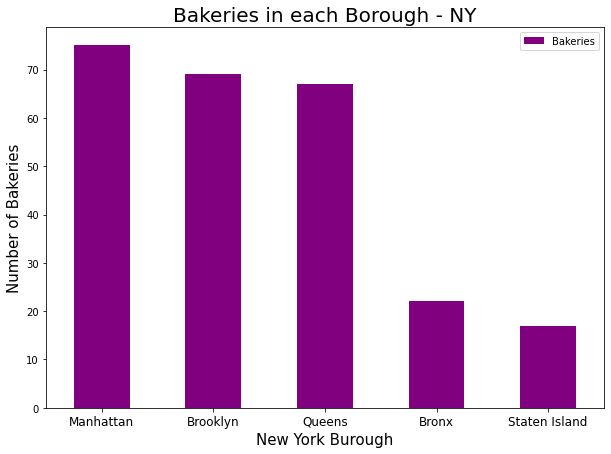

In [14]:
#Visualizing NY Boroughs with the most number of Bakeries
plt.figure(figsize = (10,7))
ny_bakery.groupby("Borough").count().sort_values(by = "Neighborhood", ascending = False)["Neighborhood"].plot(kind = 'bar', color = 'purple', label = "Bakeries")
plt.xlabel("New York Burough", fontsize = 15)
plt.ylabel("Number of Bakeries", fontsize = 15)
plt.title("Bakeries in each Borough - NY", fontsize = 20)
plt.xticks(rotation = 'horizontal', fontsize = 12)
plt.legend()
plt.show()

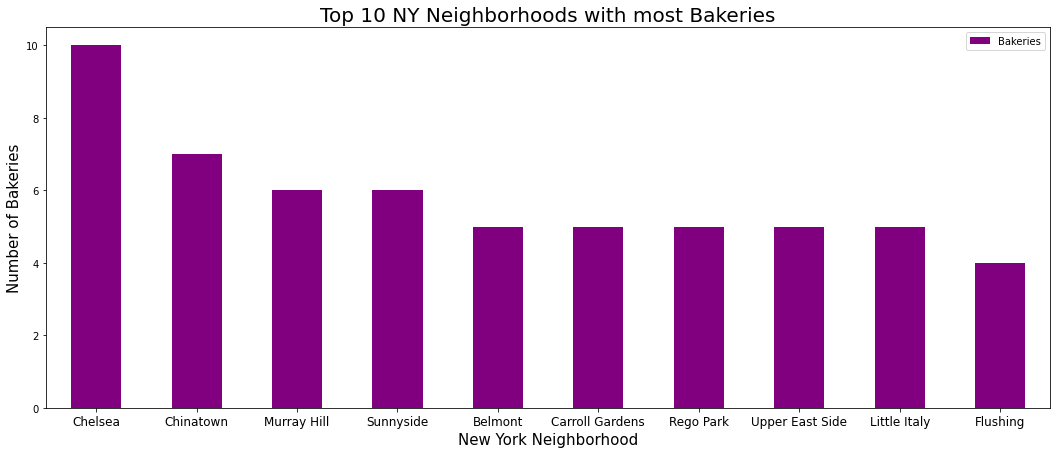

In [15]:
#Visualizing Top 10 NY Neighborhoods with the most number of Bakeries
plt.figure(figsize = (18,7))
ny_bakery.groupby("Neighborhood").count().sort_values("Venue", ascending = False)["Venue"][:10].plot(kind = 'bar', color = 'purple', label = "Bakeries")
plt.xlabel("New York Neighborhood", fontsize = 15)
plt.ylabel("Number of Bakeries", fontsize = 15)
plt.title("Top 10 NY Neighborhoods with most Bakeries", fontsize = 20)
plt.xticks(rotation = 'horizontal', fontsize = 12)
plt.legend()
plt.show()

## Based on above analysis, Manhattan is one of the best Boroughs to start a bakery. For further analysis, I am using K-Means Clustering algorithm to find similar neighborhoods in Manhattan to start a bakery. I am looking for a location that will answer the following business questions. 

1.   Must attract enough initial customer interest
2.   Must have great visibility and should be easy to find 



In [16]:
#Slicing the newyork dataset to retrieve only the neighborhoods in Manhattan
Manhattan_data = newyork_data[newyork_data["Borough"] == 'Manhattan'].reset_index(drop = True)
Manhattan_data.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [17]:
# Exploring venues in Manhattan using Foursquare API
manhattan_venues = getNearbyVenues(names = Manhattan_data["Neighborhood"], latitudes = Manhattan_data["Neighborhood Latitude"], longitudes = Manhattan_data["Neighborhood Longitude"])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
[[('Marble Hill', 40.87655077879964, -73.91065965862981, "Arturo's", 40.87441177110231, -73.91027100981574, 'Pizza Place'), ('Marble Hill', 40.87655077879964, -73.91065965862981, 'Bikram Yoga', 40.876843690797934, -73.90620384419528, 'Yoga Studio'), ('Marble Hill', 40.87655077879964, -73.91065965862981, 'Tibbett Diner', 40.8804044222466, -73.90893738006402, 'Diner'), ('Marble Hill', 40.87655077879964, -73.91065965862981, 'Starbucks', 40.87753134921497, -73.90558216359267, 'Coffee

In [18]:
# Saving the resulting data (manhattan_venues) to a .csv file due to limited calls on FourSquare
manhattan_venues.to_csv('manhattan_venues.csv', index = False)

In [19]:
# Reading data from csv file to pandas dataframe
venues_manhattan = pd.read_csv('manhattan_venues.csv')
#Printing and displaying the data
print("Number of Venues in Manhattan: ", venues_manhattan.shape[0])
venues_manhattan.head()

Number of Venues in Manhattan:  3193


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


## Data Preparation for Clustering

In [20]:
#one hot encoding the Venue Category from manhattan venues dataseset - Preparing data for Cluster analysis
manhattan_onehot = pd.get_dummies(venues_manhattan["Venue Category"], prefix="", prefix_sep="")

#add Neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = venues_manhattan["Neighborhood"]

#move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[: -1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Sm

In [21]:
#Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category - Data prep for cluster analysis
manhattan_grouped = manhattan_onehot.groupby("Neighborhood").mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Sm

## Create the new dataframe to display the top 10 venues for each neighborhood in Manhattan 

In [22]:
# Writing a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    
# Creating the new dataframe and display the top 10 venues for each neighborhood.   
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Park,Hotel,Clothing Store,Gym,Memorial Site,Shopping Mall,Wine Shop,Burger Joint,Gourmet Shop
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Cosmetics Shop,French Restaurant,Gym,Gym / Fitness Center,Bar,Bookstore,Pizza Place
2,Central Harlem,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Chinese Restaurant,Art Gallery,Seafood Restaurant,Spa,Event Space
3,Chelsea,Art Gallery,Coffee Shop,Bakery,French Restaurant,American Restaurant,Ice Cream Shop,Seafood Restaurant,Cocktail Bar,Park,Market
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Bubble Tea Shop,Ice Cream Shop,Hotpot Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,American Restaurant


# Cluster Neighborhoods in Manahattan to find neighborhoods that share similar characteristics

Running _k_-means to cluster the neighborhood into 3 clusters

In [23]:
from sklearn.cluster import KMeans

manhattan_grouped_clustering = manhattan_grouped.drop("Neighborhood", axis =1)

# run k-means clustering
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state =0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

# Add Cluster labels to the dataset containing top 10 venues per neighborhood in Manhattan

In [24]:
# adding clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = Manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Gym,Discount Store,Sandwich Place,Coffee Shop,Yoga Studio,Pizza Place,Steakhouse,Shopping Mall,Seafood Restaurant,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bakery,Cocktail Bar,Bubble Tea Shop,Ice Cream Shop,Hotpot Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,American Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Grocery Store,Deli / Bodega,Chinese Restaurant,Mobile Phone Shop,New American Restaurant,Latin American Restaurant,Park,Pizza Place
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Lounge,Restaurant,Café,Bakery,Spanish Restaurant,Frozen Yogurt Shop,Caribbean Restaurant,Chinese Restaurant,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Deli / Bodega,Cocktail Bar,Latin American Restaurant,Sushi Restaurant,Park,Yoga Studio


# Visualize the resulting clusters

In [25]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Neighborhood Latitude'], manhattan_merged['Neighborhood Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Exam the Clusters to determine the best neighborhoods in Manhattan to start a Bakery/Patisserie

# Cluster 1 

### **NOT a preferred cluster** to open a new Bakery/Patisserie. Does not answer the business questions as compared to Cluster 2 and 3.

In [26]:
manhattan_merged.loc[manhattan_merged["Cluster Labels"] ==0, manhattan_merged.columns[[1] + list(range(5,manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Bubble Tea Shop,Ice Cream Shop,Hotpot Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,American Restaurant
2,Washington Heights,Café,Bakery,Grocery Store,Deli / Bodega,Chinese Restaurant,Mobile Phone Shop,New American Restaurant,Latin American Restaurant,Park,Pizza Place
3,Inwood,Mexican Restaurant,Lounge,Restaurant,Café,Bakery,Spanish Restaurant,Frozen Yogurt Shop,Caribbean Restaurant,Chinese Restaurant,Deli / Bodega
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Deli / Bodega,Cocktail Bar,Latin American Restaurant,Sushi Restaurant,Park,Yoga Studio
5,Manhattanville,Seafood Restaurant,Coffee Shop,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Deli / Bodega,Sushi Restaurant,Climbing Gym,Supermarket,Boutique
6,Central Harlem,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Chinese Restaurant,Art Gallery,Seafood Restaurant,Spa,Event Space
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Spa,Latin American Restaurant,Sandwich Place,Taco Place,Gym,Grocery Store
9,Yorkville,Italian Restaurant,Gym,Coffee Shop,Deli / Bodega,Sushi Restaurant,Bar,Wine Shop,Diner,Japanese Restaurant,Pharmacy
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Coffee Shop,Cocktail Bar,Pizza Place,Café,Gym / Fitness Center,Gym,Burger Joint,Salad Place
12,Upper West Side,Wine Bar,Bakery,Bar,Italian Restaurant,Indian Restaurant,Café,Coffee Shop,Pizza Place,Ice Cream Shop,Mediterranean Restaurant


# Cluster 2

### Seems like the **MOST preferred cluster to start a new Bakery/Patisserie**. It has a lot of restaurants and bakeries that are among the top most venues in these Neighborhoods. 

In [27]:
manhattan_merged.loc[manhattan_merged["Cluster Labels"] ==1, manhattan_merged.columns[[1] + list(range(5,manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Gym,Discount Store,Sandwich Place,Coffee Shop,Yoga Studio,Pizza Place,Steakhouse,Shopping Mall,Seafood Restaurant,Department Store
8,Upper East Side,Italian Restaurant,Coffee Shop,Exhibit,Bakery,Gym / Fitness Center,American Restaurant,Spa,French Restaurant,Hotel,Juice Bar
11,Roosevelt Island,Park,Gym,Dry Cleaner,Bubble Tea Shop,Soccer Field,Farmers Market,Supermarket,Metro Station,School,Outdoors & Recreation
14,Clinton,Theater,Italian Restaurant,Gym / Fitness Center,Coffee Shop,American Restaurant,Gym,Spa,Wine Shop,Hotel,Sandwich Place
15,Midtown,Hotel,Clothing Store,Coffee Shop,Sporting Goods Shop,Theater,Bookstore,Café,Steakhouse,Gym,Bakery
16,Murray Hill,Coffee Shop,Sandwich Place,Bar,Japanese Restaurant,American Restaurant,Gym / Fitness Center,Burger Joint,Hotel,Mediterranean Restaurant,Taco Place
26,Morningside Heights,Coffee Shop,Park,American Restaurant,Bookstore,Burger Joint,Café,Ice Cream Shop,New American Restaurant,Supermarket,Mediterranean Restaurant
28,Battery Park City,Coffee Shop,Park,Hotel,Clothing Store,Gym,Memorial Site,Shopping Mall,Wine Shop,Burger Joint,Gourmet Shop
29,Financial District,Coffee Shop,Pizza Place,Bar,Hotel,Gym,Cocktail Bar,Park,Mexican Restaurant,Gym / Fitness Center,Sandwich Place
30,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Cosmetics Shop,French Restaurant,Gym,Gym / Fitness Center,Bar,Bookstore,Pizza Place


# Cluster 3

### Although this cluster has many restaurants among it's top venues, it does not look as popular compared to cluster 2. 

### As a result, this is **NOT a preferred cluster** to start a new Bakery/Patisserie. 

In [28]:
manhattan_merged.loc[manhattan_merged["Cluster Labels"] ==2, manhattan_merged.columns[[1] + list(range(5,manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Boat or Ferry,Coffee Shop,Heliport,Food Truck,Gas Station,Bistro,Skating Rink,Farmers Market


# Conclusion

Cluster 2 in Manhattan has the **MOST preferred neighborhoods** with a lot restaurants and bakeries among the top 10 venues. Starting a Patisserie here will yield great success and consistent profit due to high visibility, easy to locate and ability to attract enough initial customer interest. 

As a final note, all of the above analysis is dependent on the accuracy of Foursquare data. 

Future enhancements: This data and model can be used for more detailed and comprehensive analysis in the future to find **the BEST neighborhood in Cluster 2** to open a new Patisserie/Bakery.

